In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Sudoku i grover

Możemy znaleźć wszystkie możliwe rozwiązania sudoku 2x2 za pomocą algorytmu Grovera na 4 kubitach.

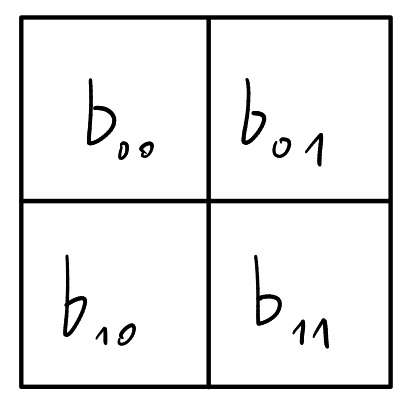

Są dwa takie rozwiązania

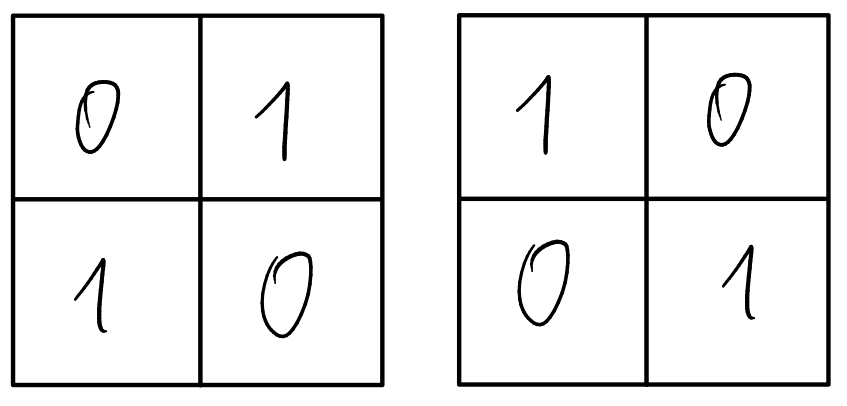

In [3]:
dev = qml.device("default.qubit", wires=5)

In [6]:
class MIKOKDevice(qml.QubitDevice):
    name = 'MIKOK Quantum Device'
    short_name = 'mikok.device'
    pennylane_requires = '>=0.30'
    version = '0.1'
    author = 'Sonovero'

    operations = {'RX', 'RY', 'RZ', 'IsingXX'}
    observables = {'PauliZ'}

    def __init__(self, wires=1, shots=1000, api_key=None, error_mitigation=None):
        super().__init__(wires, shots)

        self.api_key = api_key

    # @property
    # def stopping_condition(self):
    #     def accepts_obj(obj):
    #         return obj.name in {'RX', 'RY', 'RZ', 'IsingXX','PauliZ'}
    #     return qml.BooleanFn(accepts_obj)

    def apply(self, operations, rotations=None, **kwargs):
        for op in operations:
            pass

        for rot in rotations or []:
            pass

        # job.submit(json) #HTTP #import request

    def reset(self):
        pass

In [ ]:
dev = MIKOKDevice()

In [149]:
@qml.qnode(device=dev)
def circ():
    for _ in range(4):
        qml.Hadamard(wires=_)
    
    qml.Barrier()

    qml.CNOT(wires=[1,3])
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0,2])

    qml.CCZ(wires=[1,2,3])

    qml.CNOT(wires=[0,2])
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,3])

    qml.Barrier()

    for _ in range(4):
        qml.Hadamard(wires=_)

    for _ in range(4):
        qml.PauliX(wires=_)

    qml.Hadamard(wires=3)
    qml.MultiControlledX(wires=[0,1,2,3], work_wires=4)
    qml.Hadamard(wires=3)
    
    for _ in range(4):
        qml.PauliX(wires=_)

    for _ in range(4):
        qml.Hadamard(wires=_)


    return qml.probs(wires=range(4))

<BarContainer object of 16 artists>

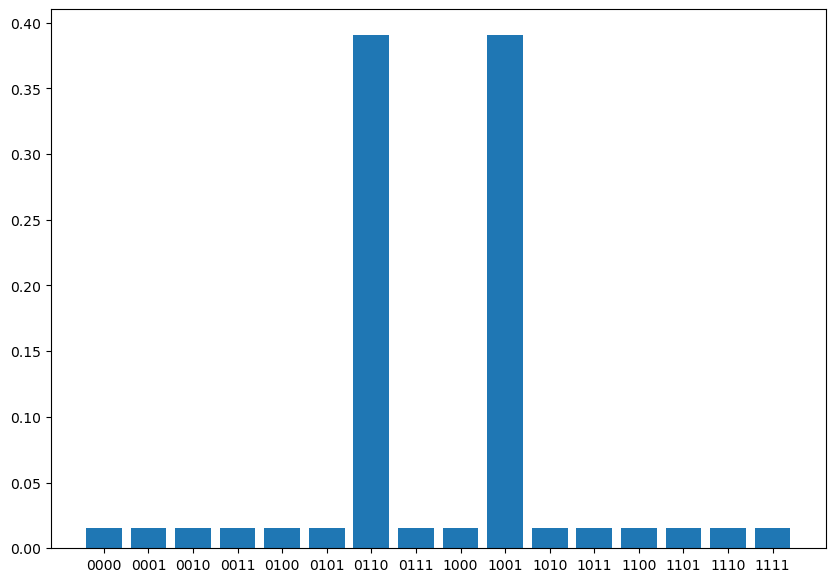

In [103]:
plt.figure(figsize=(10,7))
plt.bar([format(_,'04b') for _ in range(2**4)],circ())

# XPRIZE

In [186]:
def success_prob_2wqc(noise_gate, noise_strength):
    dev_ideal = qml.device("default.mixed", wires=5)
    dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength)
    
    def circ():
        for _ in range(4):
            qml.Hadamard(wires=_)
        
        qml.Barrier()

        qml.CNOT(wires=[1,3])
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[0,2])

        qml.MultiControlledX(wires=[1,2,3,4])

        qml.CNOT(wires=[0,2])
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[1,3])
        return qml.state()
    
    circ = qml.QNode(circ, dev_noisy)
    
    full_state = circ()
    op = np.kron(np.eye(16),[[0,1]])
    reduced_state = op.dot(full_state).dot(op.conj().T)
    reduced_state = reduced_state/reduced_state.trace()
    return np.real_if_close(reduced_state.diagonal()[6]+reduced_state.diagonal()[6])

In [187]:
def success_prob_grover(reptition, noise_gate, noise_strength):
    dev_ideal = qml.device("default.mixed", wires=5)
    dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength)

    def circ():
        for _ in range(4):
            qml.Hadamard(wires=_)
        
        for _ in range(reptition):
            qml.Barrier()

            qml.CNOT(wires=[1,3])
            qml.CNOT(wires=[0,1])
            qml.CNOT(wires=[0,2])

            qml.CCZ(wires=[1,2,3])

            qml.CNOT(wires=[0,2])
            qml.CNOT(wires=[0,1])
            qml.CNOT(wires=[1,3])

            qml.Barrier()

            for _ in range(4):
                qml.Hadamard(wires=_)

            for _ in range(4):
                qml.PauliX(wires=_)

            qml.Hadamard(wires=3)
            qml.MultiControlledX(wires=[0,1,2,3], work_wires=4)
            qml.Hadamard(wires=3)
            
            for _ in range(4):
                qml.PauliX(wires=_)

            for _ in range(4):
                qml.Hadamard(wires=_)

        return qml.probs(wires=range(4))
    
    circ = qml.QNode(circ, dev_noisy)
    
    full_state = circ()
    
    return np.real_if_close(full_state[6]+full_state[6])

In [153]:
# Describe noise
# noise_gate = qml.PhaseDamping
noise_gate = qml.BitFlip
noise_strength = 0.1

dev_ideal = qml.device("default.mixed", wires=5)
dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength)

(<Figure size 2000x500 with 1 Axes>, <Axes:>)

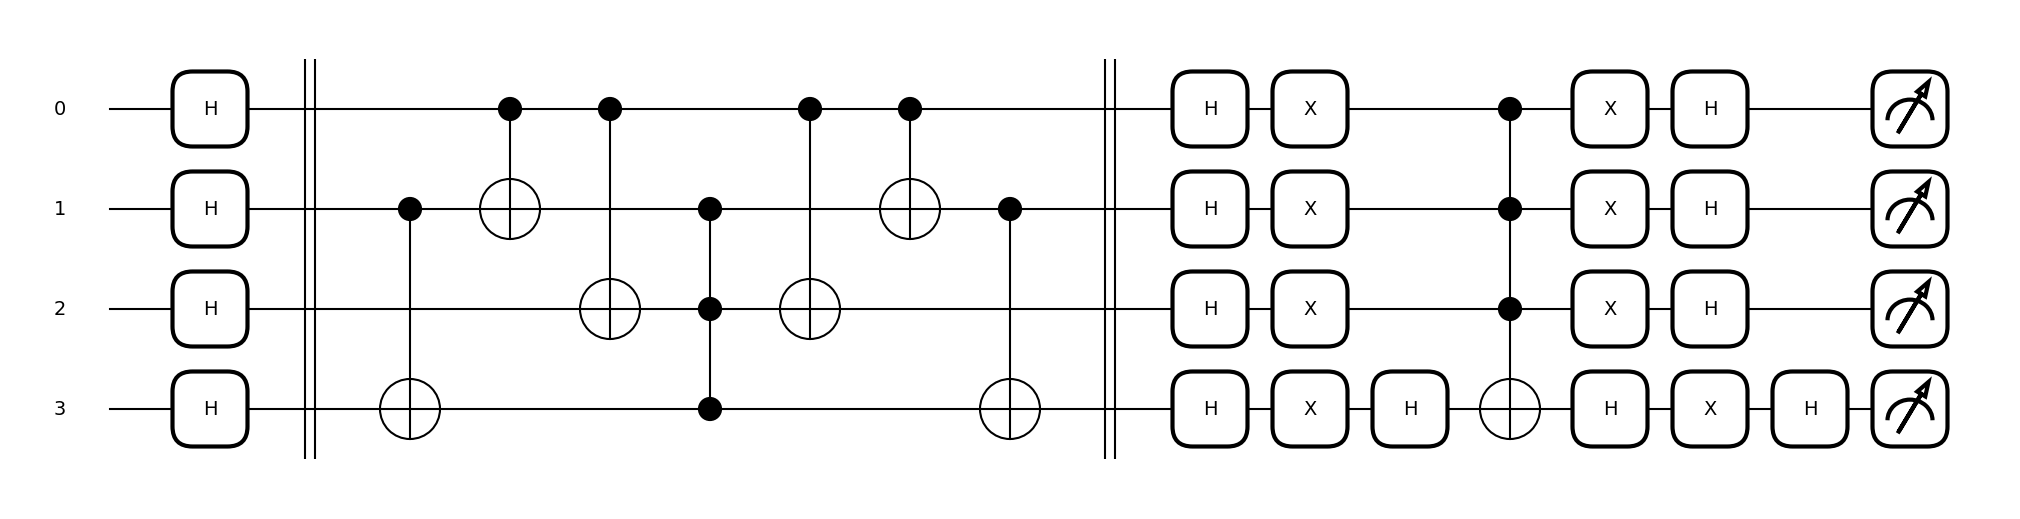

In [172]:
qml.draw_mpl(qcirc)()

In [173]:
full_state = qcirc()
op = np.kron(np.eye(16),[[0,1]])
reduced_state = op.dot(full_state).dot(op.conj().T)
reduced_state = reduced_state/reduced_state.trace()
plt.figure(figsize=(10,7))
plt.bar([format(_,'04b') for _ in range(2**4)],np.real_if_close(reduced_state.diagonal()))

ValueError: shapes (16,32) and (16,) not aligned: 32 (dim 1) != 16 (dim 0)

In [214]:
noise = np.linspace(0,1,100)
noise_gate = qml.PhaseFlip
prob_2wqc = [success_prob_2wqc(noise_gate, n) for n in noise]
prob_grover_1 = [success_prob_grover(1, noise_gate, n) for n in noise]
prob_grover_2 = [success_prob_grover(2, noise_gate, n) for n in noise]

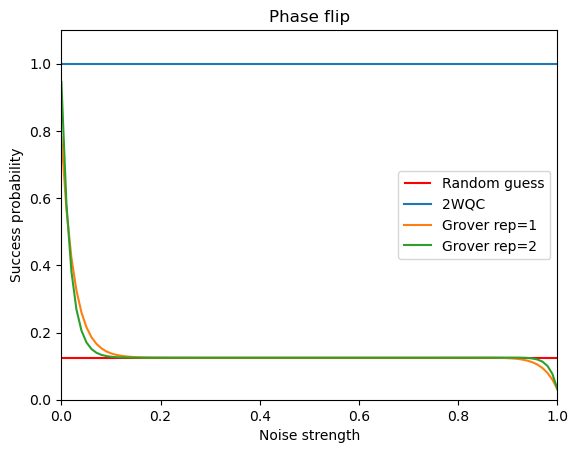

In [215]:
plt.hlines(2/16,0,1, color='red', label='Random guess')
plt.plot(noise, prob_2wqc, '-', label='2WQC')
plt.plot(noise, prob_grover_1, '-', label='Grover rep=1')
plt.plot(noise, prob_grover_2, '-', label='Grover rep=2')
plt.ylim(0,1.1)
plt.xlim(0,1)
plt.legend()
plt.xlabel('Noise strength')
plt.ylabel('Success probability')
plt.title('Phase flip')
plt.savefig('PhaseFlip.png')

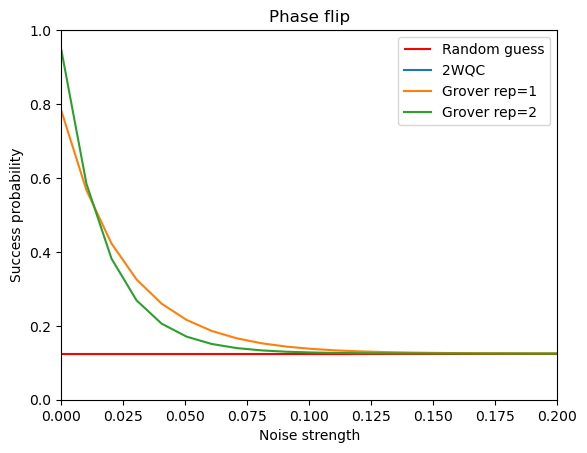

In [216]:
plt.hlines(2/16,0,1, color='red', label='Random guess')
plt.plot(noise, prob_2wqc, '-', label='2WQC')
plt.plot(noise, prob_grover_1, '-', label='Grover rep=1')
plt.plot(noise, prob_grover_2, '-', label='Grover rep=2')
plt.ylim(0,1)
plt.xlim(0,0.2)
plt.legend()
plt.xlabel('Noise strength')
plt.ylabel('Success probability')
plt.title('Phase flip')
plt.savefig('PhaseFlip_zoom.png')